In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import imutils
import scipy.stats as stats

In [3]:
## Ne garder que les images non câblées

liste_non_cablees=[]
dossier="ModulePictures"

for fichier in os.listdir(dossier):
    if os.path.isfile(os.path.join(dossier, fichier)) and ("Reception" in os.path.basename(fichier)):
        liste_non_cablees.append(str(dossier + "/"+ os.path.basename(fichier)))

## Ne garder que les images câblées

liste_cablees=[]
dossier="ModulePictures"

for fichier in os.listdir(dossier):
    if os.path.isfile(os.path.join(dossier, fichier)) and ("AfterBonding" in os.path.basename(fichier)):
        liste_cablees.append(str(dossier + "/"+ os.path.basename(fichier)))


In [4]:
def mires(img_input, draw = False):
    
    assert img_input is not None, "file could not be read, check with os.path.exists()"

    img = cv.cvtColor(img_input,cv.COLOR_BGR2GRAY)

    (height,length) = img.shape

    ## TODO : changer cette extraction à la main par quelque chose d'automatisé
    sliceparams = [(100, 400, 300, 600, 1),  
                   (-400, -100, 300, 600, 1),
                   (3800, 4200, 500, 800, 2), 
                   (100, 400, -600,-300, 1), 
                   (-400, -100, -600, -300, 1), 
                   (3800, 4200, -800, -500, 2)]

    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

    centers = []

    for (beg1, end1, beg2, end2, nbmires) in sliceparams :
        mask = img[beg1:end1, beg2:end2]

        #Blur pour réduire le bruit
        mask = cv.medianBlur(mask,5)
        #Fonction qui détecte les cercles.
        circles = cv.HoughCircles(mask,cv.HOUGH_GRADIENT,1,minDist = 100,
                                    param1=50,param2=20,minRadius=20 ,maxRadius=30)

        if circles is not None:
            circles = np.int16(np.around(circles))
            for i in circles[0,:nbmires]:
                
                centers.append([i[0]+beg2%length,i[1]+beg1%height])

                #Dessin des cercles
                if draw :
                    cv.circle(cimg,(i[0]+beg2%length,i[1]+beg1%height),i[2],(0,255,0),20)
                    cv.circle(cimg,(i[0]+beg2%length,i[1]+beg1%height),2,(0,0,255),3)

    if draw :
        plt.imshow(cimg)
        plt.show()

    assert len(centers) == 8, "Mires manquantes"

    slope = sum([(centers[i+4][0]-centers[i][0])/(centers[i+4][1]-centers[i][1]) for i in range(0,4)])/4

    return np.array(centers),slope

In [21]:
#Détection à la main de la frontière supérieure verte :

def horiz_pcb(img) :

    lower_bound = np.array([0, 40, 0])
    upper_bound = np.array([40,110,110])
    bwimg = cv.inRange(img, lower_bound, upper_bound)
    imagemask_green = cv.medianBlur(bwimg,25)

    middle = img.shape[1]//2

    top_contour = np.zeros((1000,2),dtype=np.int32)
    bot_contour = np.zeros((1000,2),dtype=np.int32)

    for j in range(middle - 2000, middle - 1000, 2) :

        top_contour[(j - middle + 2000)//2] = [j,min(np.where(imagemask_green[:,j] == 255)[0])]
        bot_contour[(j - middle + 2000)//2] = [j,max(np.where(imagemask_green[:,j] == 255)[0])]

    for j in range(middle + 1000, middle + 2000, 2) : 

        top_contour[(j - middle)//2] = [j,min(np.where(imagemask_green[:,j] == 255)[0])]
        bot_contour[(j - middle)//2] = [j,max(np.where(imagemask_green[:,j] == 255)[0])]

    slopes = [stats.linregress(top_contour[:,0], top_contour[:,1]).slope, stats.linregress(bot_contour[:,0], bot_contour[:,1]).slope]
    intercepts = [int(stats.linregress(top_contour[:,0], top_contour[:,1]).intercept), int(stats.linregress(bot_contour[:,0], bot_contour[:,1]).intercept)]

    spacing = bot_contour[:,1]-top_contour[:,1]

    return slopes,intercepts,np.mean(spacing)

In [22]:
horiz_pcb(cv.imread(liste_cablees[1]))

([np.float64(-0.002105243872177696), np.float64(-0.0015660332237190321)],
 [173, 5413],
 np.float64(5241.684))

In [7]:
## Fonctions utiles

def tourner_image(image, pente):
    return imutils.rotate(image, np.arctan(pente))

def trouver_la_paire(fichier, dossier):
    bname=os.path.basename(fichier)
    if "AfterBonding" in bname:
        name=bname[:bname.find("AfterBonding")]
        for f in os.listdir(dossier):
            if "Reception" in os.path.basename(f):
                if os.path.basename(f)[:os.path.basename(f).find("Reception")]==name:
                    return f
    elif "Reception" in bname:
        name=bname[:bname.find("Reception")]
        for f in os.listdir(dossier):
            if "AfterBonding" in os.path.basename(f):
                if os.path.basename(f)[:os.path.basename(f).find("AfterBonding")]==name:
                    return f
    return "Pas de paire"

In [8]:
trouver_la_paire(liste_cablees[0],"ModulePictures")

'20UPGM23210250_PPPV2_45_Reception_Glo_NoLight_AfterClean.jpg'

In [9]:
def afficher(img) :
    cv.imshow("Image", img)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [10]:
def rotation_mires(path): #prend en argument une image cablée, renvoie la rotation des mires.
    img_cablee = cv.imread(path)
    path_non_cablee = 'ModulePictures/' + trouver_la_paire(path,"ModulePictures")
    img_non_cablee = cv.imread(path_non_cablee)

    relative_slope = horiz_pcb(img_non_cablee)[0] - mires(img_non_cablee)[1]

    return tourner_image(img_cablee, horiz_pcb(img_cablee)[0] - relative_slope)

In [11]:
def trouve_cercle(img):
    
    assert img is not None, "file could not be read, check with os.path.exists()"

    (height,width) = img.shape

    img = img[height//8 : height//3, width//2 - 500 : width//2 + 500]

    img = cv.medianBlur(img,5)
    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

    circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,1e5,
                                param1=50,param2=30,minRadius=200,maxRadius=400)

    circles = np.uint16(np.around(circles))

    return circles[0,0][:2] + [width//2 - 500, height//8]

In [13]:
def trouve_ligne(img):

    (height,width) = img.shape

    img = img[height//3 : height//2, width//2 - 200 : width//2 + 200]

    img = cv.medianBlur(img,3)

    dst = cv.Canny(img, 50, 200, None, 3)

    lines = cv.HoughLines(dst, 1, np.pi / 360, 220, None, 0, 0,min_theta=-np.pi/8, max_theta=np.pi/8)

    lines = lines[:2,0,:]

    median_line = np.mean(lines,axis=0)

    return median_line, width//2 - 200, height//2
    #return ([int(lines[0,0,0]/np.cos(lines[0,0,1]) + width//2 - 200), height//2], [int(lines[1,0,0]/np.cos(lines[1,0,1]) + width//2 - 200), height//2])

In [14]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [15]:
def matrice_psg(img):
    [rho,theta],alpha,beta = trouve_ligne(cv.cvtColor(img,cv.COLOR_BGR2GRAY))
    [_,c],[_,d], dilatation = horiz_pcb(img) #Droite horizontale y = cx + d

    if theta==0 :
        pt_intersection = (int(alpha + rho), int(c*(alpha+rho) + d))
        vert_vector = np.array([0,1])
    else :

        a = -(np.cos(theta)/np.sin(theta))
        b = rho/np.sin(theta) + beta - alpha/np.tan(theta) #Droite verticale y = ax + b

        x = int((d-b)/(a-c))
        pt_intersection = (x,int(a*x+b))

        vert_vector = normalize(np.array([1,a]))
    
    horiz_vector = normalize(np.array([1,c]))

    matrice_passage = np.transpose(np.array([horiz_vector,vert_vector])) #Matrice de passage de l'espace normal à l'espace qui nous intéresse

    return matrice_passage, pt_intersection, dilatation
    

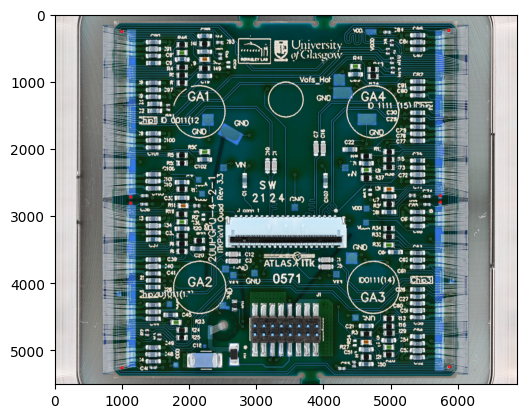

In [29]:
path = liste_cablees[9]

img_cablee = cv.imread(path)
img_non_cablee = cv.imread('ModulePictures/' + trouver_la_paire(path,"ModulePictures"))

centres_mires,_ = mires(img_non_cablee)

## ON TROUVE DANS L'ESPACE DE BASE L'EXPRESSION DE LA POSITION DES MIRES

matrice_passage_init, pt_intersection_init, dilatation_init = matrice_psg(img_non_cablee)

## ON RETROUVE L'ESPACE ASSOCIE A LA CARTE PCB SUR L'IMAGE CABLEE

matrice_passage_dst, pt_intersection_dst, dilatation_dst = matrice_psg(img_cablee)

dilatation = dilatation_dst/dilatation_init

nouveaux_centres = []
for centre in centres_mires:
    nouveaux_centres.append(np.dot(np.linalg.inv(matrice_passage_dst),dilatation*np.dot(matrice_passage_init,centre - pt_intersection_init)) + pt_intersection_dst)

nouveaux_centres = np.array(nouveaux_centres).astype(np.int16)

for centre in nouveaux_centres :
    cv.circle(img_cablee, centre, 15, (255,0,0), 15)

afficher(img_cablee)

plt.imshow(img_cablee)
plt.show()
